In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import os

In [29]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Is TensorFlow using GPU? ", tf.test.is_built_with_cuda())
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  1
Is TensorFlow using GPU?  True
TensorFlow version:  2.17.0


In [30]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')


Found 28232 validated image filenames belonging to 9 classes.
Found 7059 validated image filenames belonging to 9 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


883/883 ━━━━━━━━━━━━━━━━━━━━ 809s 898ms/step - accuracy: 0.1858 - loss: 3.6483 - val_accuracy: 0.2519 - val_loss: 2.0126 - learning_rate: 0.0010
Epoch 2/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 662s 744ms/step - accuracy: 0.2196 - loss: 2.0685 - val_accuracy: 0.2520 - val_loss: 1.9848 - learning_rate: 0.0010
Epoch 3/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 655s 737ms/step - accuracy: 0.2210 - loss: 2.0618 - val_accuracy: 0.2585 - val_loss: 1.9806 - learning_rate: 0.0010
Epoch 4/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 660s 741ms/step - accuracy: 0.2287 - loss: 2.0502 - val_accuracy: 0.2602 - val_loss: 1.9861 - learning_rate: 0.0010
Epoch 5/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 659s 741ms/step - accuracy: 0.2265 - loss: 2.0461 - val_accuracy: 0.2602 - val_loss: 1.9744 - learning_rate: 0.0010
Epoch 6/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 656s 738ms/step - accuracy: 0.2320 - loss: 2.0379 - val_accuracy: 0.2631 - val_loss: 1.9569 - learning_rate: 0.0010
Epoch 7/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 656s 738ms/step - accuracy: 0.2272 

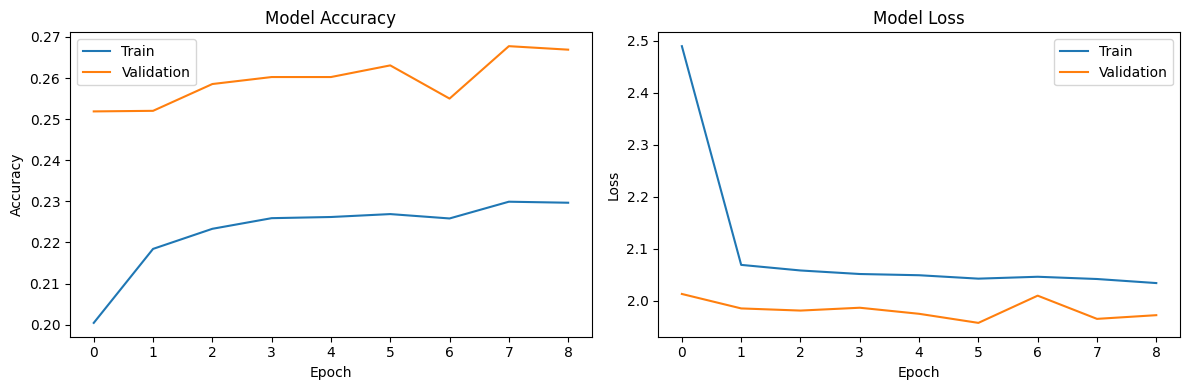

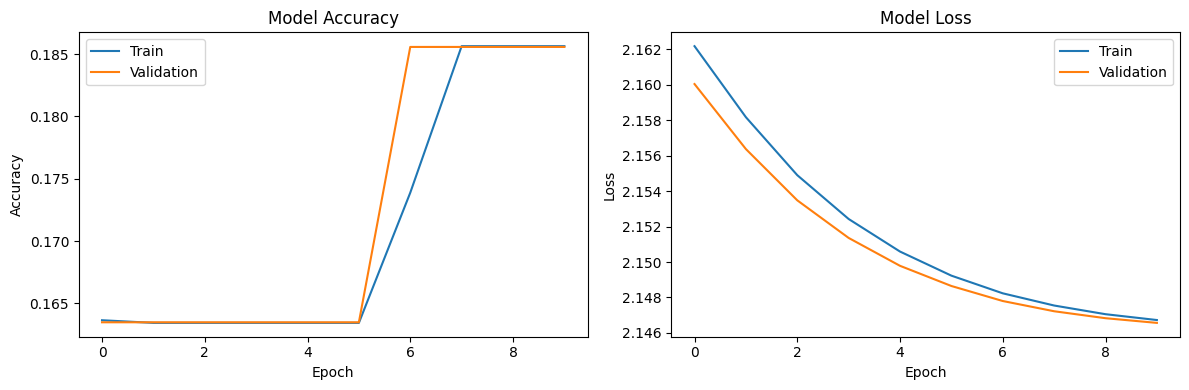

In [31]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Constants
IMG_SIZE = 224  # VGG16 input size
BATCH_SIZE = 32
EPOCHS = 20
BASE_PATH = '/kaggle/input/car-brand/Public/Public'
weights_path = '/kaggle/input/vgg16-weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Replace with your weights file path

# Read and prepare the dataset
df = pd.read_csv('/kaggle/input/car-brand/CarDataset.csv', header=None, names=['filename', 'label'])
df['label'] = df['label'].astype(str)

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    BASE_PATH,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    BASE_PATH,
    x_col='filename',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load VGG16 model with custom weights
base_model = VGG16(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.load_weights(weights_path)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2
        )
    ]
)

# Fine-tuning
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2
        )
    ]
)

# Save the model
model.save('car_brand_classifier_vgg16.h5')

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])
    
    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)
plot_training_history(history_fine)